<a href="https://colab.research.google.com/github/yodavo/moja-global-analysis/blob/main/2021-12-08_Task0-MOESM/Hamon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [154]:
# Install GDAL and Geopandas
!apt install gdal-bin python-gdal python3-gdal -q
!apt install python3-rtree -q
!pip install geopandas -q
!pip install descartes -q

# Folium 
!pip install folium -q

# for rasters
!pip install Rasterio -q
!pip install rasterstats -q
!pip install georasters -q

# Install Pysal - Spatial Statistics
!pip install pysal -q
!pip install splot -q

# For data analysis
# !pip install dataprep -q

Reading package lists...
Building dependency tree...
Reading state information...
gdal-bin is already the newest version (2.2.3+dfsg-2).
python-gdal is already the newest version (2.2.3+dfsg-2).
python3-gdal is already the newest version (2.2.3+dfsg-2).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
Reading package lists...
Building dependency tree...
Reading state information...
python3-rtree is already the newest version (0.8.3+ds-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [155]:
# For analysis
import os, zipfile, glob
import pandas as pd
import numpy as np
from patsy import dmatrices
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.formula.api as smf
import statsmodels.api as sm

# For GIS
import geopandas as gpd
import rasterio,  gdal
import rasterstats
from rasterio.plot import show
from rasterio.plot import show_hist
from shapely.geometry import Point

# For plots
from matplotlib import pyplot as plt
import seaborn as sns
from pprint import pprint

In [156]:
# Supplementary material
url = 'https://github.com/yodavo/moja-global-analysis/blob/fb5cb416f802ca5668d9c991821ce8c45e69bc61/2021-12-08_Task0-MOESM/datasets/13021_2019_136_MOESM2_ESM.xlsx?raw=true'
xl = pd.ExcelFile(url)

In [157]:
# sheet view
xl.sheet_names

['Data for analysis',
 'Data sources',
 'Notes and codes',
 'Genus and family',
 'Locations',
 'WClim data',
 'Sheet3']

In [158]:
# Useful datasets
dataset = [pd.read_excel(url, na_values=['.', -99, 'na'], sheet_name = 'Data for analysis', skipfooter=1),
           pd.read_excel(url, na_values=['.', -99, 'na'], sheet_name = 'Genus and family'),
           pd.read_excel(url, na_values=['.', -99, 'na'], sheet_name = 'Locations'), 
           pd.read_excel(url, na_values=['.', -99, 'na'], sheet_name = 'WClim data', skiprows=4)]

In [159]:
# cleaning and fixing mistakes from excelf
dataset_clean = []
for i in dataset:
  # turn headers into lowercase and remove white spaces
  i.rename(columns=lambda x: x.strip(), inplace=True)
  i.rename(columns=lambda x: str.lower(x), inplace=True)
  i.rename(columns=lambda x: x.replace(' ', '_'), inplace=True)
  i.rename(columns=lambda x: x.replace('_c_', 'c'), inplace=True)
  i.rename(columns=lambda x: x.replace('_(', '('), inplace=True)
  # clean empty columns
  i = i.loc[:,~i.columns.str.contains('^unnamed', case=False)]
  # review header and tail to avoid empty rows
  # display(i.head(3))
  # display(i.tail(3))
  # append
  dataset_clean.append(i)

# **PAPER SUMMARY - NOTES**

## **Objective**
> **Refine the understanding of how recent increases in tree mortality could affect the global carbon balance.**

## **Methods**
1. Review what is currently known about the decomposition of *coarse woody detritus* (CWD) in boreal, temperate and tropical forests.
2. Examinating general factors that influence the rate at which CWD decomposes including tree species, size, position (i.e., standing versus downed), canopy openness, and climate.
3. Explore the implications of observed decomposition rates on modeling carbon release, examine a range of current modeling approaches, and make suggestions for the next steps in quantifying and modeling this important process.

## **Data Sources**
- Published studies of decomposition rates we selected those based for the most part on individual pieces of CWD.
- Unpublished data we used our own databases which have been gathered over the course of several decades.
- Estimates based on the ratio of mortality and an assumption that the observed store was in  steady-state.
- Site description data when provided by the articles.
- Not inventories of stores/stock [39] or models [40-43].

For a **populations of dead woods** one may estimate the decomposition rates constants from the ratio of dead wood input to stores.

**Climate** was characterized by mean annual temperature (MAT) and average total annual precipitation (TAP). Also but not primary Worldclim2 at 2.5 min data.

## **1. Rate of decomposition**

<center>
$M_{t} = Mo_{e}^{-tk}$
</center>

- **M** is the metric of choice (mass, volume, or density).
- **t** is time.
- **k** is the rate-constant of decomposition.

## **Analysis**
Analysis of all **k values** found, because the rate-constants calculated from these different combinations differ less than between studies (*ceteris paribus*) or species.

Using alternative methods to document the effect of the factors of interest:
1. Noted whether a factor had been examined and an effect had been reported.
2. Quantify the sign and magnitude of the effect.
3. For:
  - *Species effects*, using the ratio of the fastest to the slowest decomposition-rate constant.
  - *Position effects*, used the ratio of standing dead to downed dead decomposition rate-constant as the index.
  - *Size*, only noted the sign of the effect given that range of sizes examined was so variable that a comparison of magnitude could be misleading.
  - *Comparison of open-versus closed-canopy sites*, noted the sign of the effect in part because there were few studies that actually made this comparison and hence an average magnitude would be too uncertain.

In the case of **three variables**, initial wood density (IWD), MAT, and TAP, it was possible to use regression analysis to assess an effect; however, even here caution must be exercised in interpretation as many other factors (e.g., species decay resistance, size, and position) could be confounded with these variables.

1. **IWD** - statistical models we used linear regression (assess for the k estimates associated with IWD to asses relationship between all the dataset and each major forest).
2. **TAP** - liear an polynomial regression (asees relationships with k and did not examine the effect of seasonality).
3. **MAT** - Non linear regression (to determinine the Q10 -Quotient 10- for the whole dataset vs the downed CWD).

Used a sensitivity analysis to explore the potential effects of species differences and the transfer of CWD from one position (standing) to another (downed).

Two aspects of species effects were examined: the difference among species in terms of 
1. **k**
2. **abundance**

It was modelled decomposition for a total of 10 “species” with a ratio of fastest to slowest *k*  ranging between either 1, 2, 4, 8, or 16.

The first ratio indicated all species had identical k’s, whereas the latter indicated up to a 16-fold difference among species.

Five different abundance patterns of species were assessed: 
1. **uniform** (i.e., all the species contributed the same amount of input).
2. **normal distribution** in which the species with average k’s made the greatest contribution
3. **Bimodal distribution** in which fastest and slowest decomposing species made the greatest contribution.
4. **“slow” biased distribution** in which slowest decomposing species made the greatest contribution.
5. **“fast” biased distribution** in which the
fastest decomposing species made the greatest contribution.

To assess the effects of variation in *k* and species abundance we used the relative difference in carbon flux between a particular case and the reference case in which all species had the same *k*.

It was assumed that the k of maximum decomposition of snags was 0.05 per year (due time frames 15-30-60 years).

**Slags decomopse < logs**

Finally:
1. There where 2 pools (dead and live).
2. The NPP base-level was assumed to be 2 MgC/ha/year.
3. The mortality base-level was assumed to be 0.01 per year, (maximum tree life-span -majority - of 460 years). 
4. Three base-levels of decomposition rate-constants were used: 0.025, 0.05, and 0.1.
5. NEP was calculated as NPP minusd ecomposition-related losses which were assumed to be primarily from respiration.

## **Bases of decomposition**
The course of decomposition can be described using volume, mass, or density loss of a piece of CWD; moreover, different equation types can be used to determine a rate of loss.

There are three basic methods for determining decomposition rates of individual CWD pieces and each may give a different estimate:
1. **Chronosequences** (the most common) substitution in time.
2. **Time series** individual pieces over time.
3. **Decomposition vector** combined chronosequences and time series (in a wide ranges of ages over two points in time).


# **Results**

In [160]:
# check column names
dataframe = []
for i in dataset_clean:
  dataframe.append(i.columns.tolist())

# show colums in df
pd.DataFrame(dataframe)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32
0,genus,species,subspecies,family,climate_zone,forest_type,positon,diameters(cm),model_type,target_variable,k(per_year),stderr_k(per_year),decay_resistance,initial_density(mg_per_m_cubed),reported_precipitation(mm_per_year),reported_temperature(c),wc_precipitation(mm_per_year),wc_temperature(c),reference,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,genus,family,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,location,forest_type,latitude,longitude,reference,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,oid_,location,forest_typ,latitude,longitude,reference,y,x,comments,wc2_p01,wc2_p02,wc2_p03,wc2_p04,wc2_p05,wc2_p06,wc2_p07,wc2_p08,wc2_p09,wc2_p10,wc2_p11,wc2_p12,wc2_tavg01,wc2_tavg02,wc2_tavg03,wc2_tavg04,wc2_tavg05,wc2_tavg06,wc2_tavg07,wc2_tavg08,wc2_tavg09,wc2_tavg10,wc2_tavg11,wc2_tavg12


### **Review the `data` dataset**



In [161]:
# variables
data = dataset_clean[0]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295 entries, 0 to 294
Data columns (total 19 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   genus                                295 non-null    object 
 1   species                              295 non-null    object 
 2   subspecies                           7 non-null      object 
 3   family                               282 non-null    object 
 4   climate_zone                         295 non-null    object 
 5   forest_type                          295 non-null    object 
 6   positon                              295 non-null    object 
 7   diameters(cm)                        286 non-null    object 
 8   model_type                           295 non-null    object 
 9   target_variable                      290 non-null    object 
 10  k(per_year)                          295 non-null    float64
 11  stderr_k(per_year)              

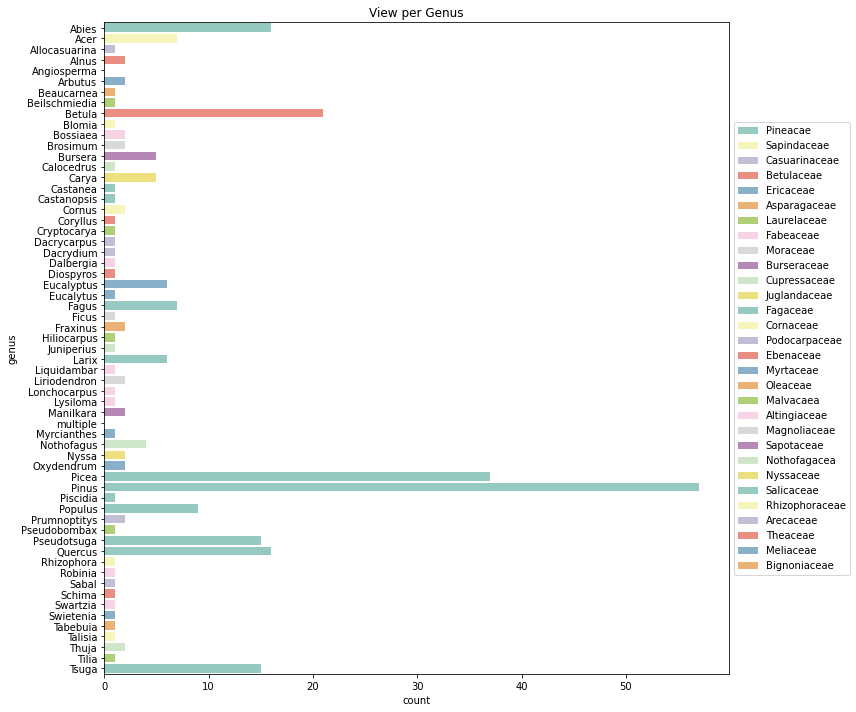

In [162]:
# Review taxonomic information
fig, ax = plt.subplots(1,1, figsize=(12,10))
sns.countplot(y='genus', hue='family',
              dodge=False, data=data, 
              ax=ax, palette='Set3')
ax.set_title('View per Genus')
ax.axis()
plt.legend(loc='center left', bbox_to_anchor=(1., 0.5))
plt.tight_layout()
plt.show()

In [163]:
# reviewing objects
data.climate_zone.value_counts() 
# also: forest_type,positon, model_type,target_variable

Temperate    182
Boreal        74
Tropical      39
Name: climate_zone, dtype: int64

In [164]:
# reviewing numeric information
data['diameters(cm)'] = data['diameters(cm)'].str.replace(' ','')
data['diameters(cm)'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


>10     132
5-15     14
15       14
0        11
>2        7
       ... 
5-10      1
6.3       1
>20       1
1-60      1
5-20      1
Name: diameters(cm), Length: 73, dtype: int64

**No more things to fix in others variables**\
`k(per_year), stderr_k(per_year), decay_resistance,initial_density(mg_per_m_cubed), reported_precipitation(mm_per_year), wc_precipitation(mm_per_year), 'wc_temperature(c)`

# **1. Location of study sites**

In [165]:
# decimal minutes seconds to decimal coordenates
def dms2dd(statement):
  # assuming all the staments ended with ['N', 'S', 'E', 'W']
  coordinate = statement[:-1]
  direction = statement[-1]

  # modification
  coordinate = float(coordinate)
  modify = [-1 if direction in ['W', 'S'] else 1]
  new = coordinate * modify[0]
  return new

Location dataframe shape:  (111, 4)


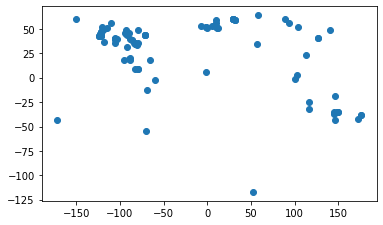

In [166]:
# getting the information from dataset
locations = dataset_clean[2].copy()

# fixing coordenates white spaces
df_obj = locations.select_dtypes(['object'])
locations[df_obj.columns] = df_obj.apply(lambda x: x.str.rstrip())
locations['latitude'] = locations['latitude'].apply(dms2dd)
locations['longitude'] = locations['longitude'].apply(dms2dd)

# creating geometry
geometry = [Point(xy) for xy in zip(locations['longitude'], locations['latitude'])]
locations = locations.drop(columns=['reference']) # removing from df
print('Location dataframe shape: ', locations.shape)

# creating geodataframe
glocation = gpd.GeoDataFrame(locations, crs="EPSG:4326", geometry=geometry)
glocation.plot()
plt.show()

Location dataframe shape:  (109, 5)


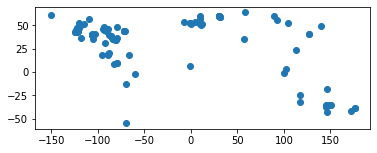

In [167]:
# I guess the dataset has 2 mistaken points (check latitude < -100 and longitude <-160)
# Maybe they are missplace but I will ommit then this time
locations = locations.drop(locations[locations['latitude'] < -100].index)
locations = locations.drop(locations[locations['longitude'] < -160].index)
locations.reset_index(drop=True, inplace=True)

# creating geometry
geometry = [Point(xy) for xy in zip(locations['longitude'], locations['latitude'])]
print('Location dataframe shape: ', locations.shape)

# creating geodataframe and plotting for review
glocation = gpd.GeoDataFrame(locations, crs="EPSG:4326", geometry=geometry)
glocation.plot()
plt.show()

In [168]:
# geodataframes worldwide border
world_df = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# world_df.plot()
# plt.show()

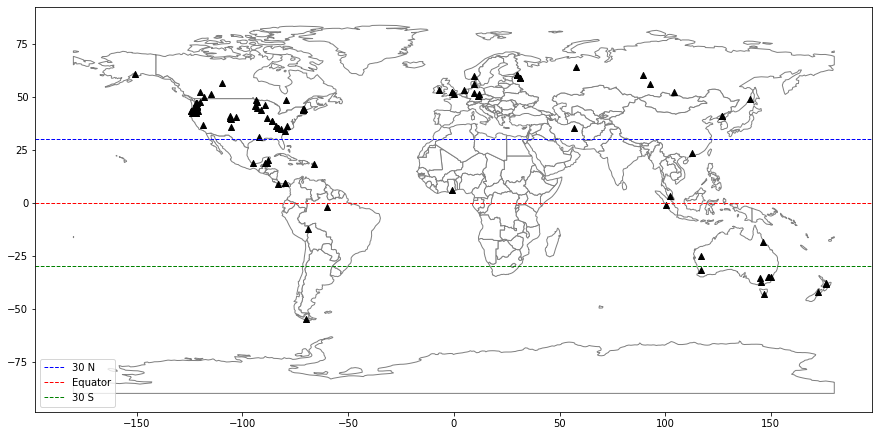

In [169]:
# plotting
ax = world_df.plot(figsize=(15,10), color='w', edgecolor='grey')
glocation.plot(ax=ax, color='k', marker='^')
# reference longitude
plt.axhline(30, linewidth=1, color='b',linestyle='--', label='30 N')
plt.axhline(0, linewidth=1, color='r',linestyle='--', label='Equator')
plt.axhline(-30, linewidth=1, color='g',linestyle='--', label='30 S')
plt.legend(loc=3)
plt.show()

# **2. Climate (TAP vs. MAT)**

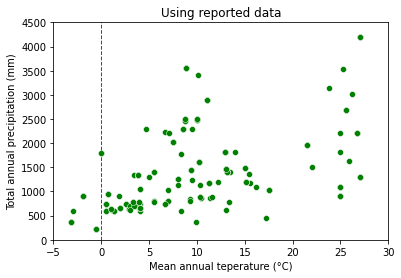

In [170]:
# Climatic conditions of decomposition studies for coarse worry detritus based
# on climate reported studies
reported = data[['reported_temperature(c)', 'reported_precipitation(mm_per_year)']].copy()

# fixing -99 empty data
reported['reported_temperature(c)'] = np.where(reported['reported_temperature(c)']== -99, np.nan, reported['reported_temperature(c)'])
reported['reported_precipitation(mm_per_year)'] = np.where(reported['reported_precipitation(mm_per_year)']== -99, np.nan, reported['reported_precipitation(mm_per_year)'])

# scatterplot
fig, ax = plt.subplots(1,1)
ax = sns.scatterplot(data=reported, 
                x='reported_temperature(c)', 
                y='reported_precipitation(mm_per_year)',
                color='green')
ax.set(xlabel='Mean annual teperature (°C)', ylabel='Total annual precipitation (mm)', title = 'Using reported data',
       xlim=(-5,30),ylim=(0,4500))
plt.axvline(0, linewidth=1, color='r',linestyle='--')
plt.show()

**Note**... quite different than the one described in the paper. Especially in the 20-30 range.

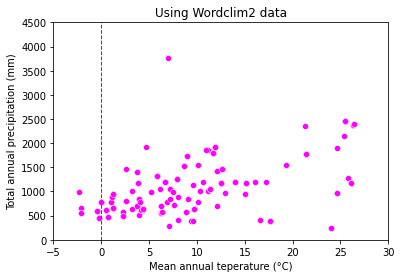

In [171]:
# Climatic conditions of decomposition studies for coarse worry detritus based
# on climate reported studies
wclim = data[['wc_temperature(c)', 'wc_precipitation(mm_per_year)']].copy()

# fixing -99 empty data
wclim['wc_temperature(c)'] = np.where(wclim['wc_temperature(c)']== -99, np.nan, wclim['wc_temperature(c)'])
wclim['wc_precipitation(mm_per_year)'] = np.where(wclim['wc_precipitation(mm_per_year)']== -99, np.nan, wclim['wc_precipitation(mm_per_year)'])

# scatterplot
fig, ax = plt.subplots(1,1)
ax = sns.scatterplot(data=wclim, 
                x='wc_temperature(c)', 
                y='wc_precipitation(mm_per_year)',
                color='magenta')
ax.set(xlabel='Mean annual teperature (°C)', ylabel='Total annual precipitation (mm)', title = 'Using Wordclim2 data',
       xlim=(-5,30),ylim=(0,4500))
plt.axvline(0, linewidth=1, color='r',linestyle='--')
plt.show()

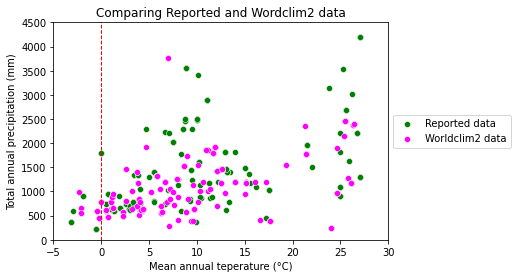

In [172]:
# Comparing both plots
# scatterplot
fig, ax = plt.subplots(1,1)
ax = sns.scatterplot(data=reported, 
                x='reported_temperature(c)', 
                y='reported_precipitation(mm_per_year)',
                color='green', label='Reported data')
ax = sns.scatterplot(data=wclim, 
                x='wc_temperature(c)', 
                y='wc_precipitation(mm_per_year)',
                color='magenta', label='Worldclim2 data')
ax.set(xlabel='Mean annual teperature (°C)', ylabel='Total annual precipitation (mm)', title = 'Comparing Reported and Wordclim2 data',
       xlim=(-5,30),ylim=(0,4500))
plt.axvline(0, linewidth=1, color='r',linestyle='--')
plt.legend(loc='center left', bbox_to_anchor=(1., 0.5))
plt.show()

# **3. Relationship between initial wood density (IWD) and decomposition rate-constant (k)**

In [221]:
# Review
relationship = data[['climate_zone', 'initial_density(mg_per_m_cubed)', 'k(per_year)']].copy()
relationship.rename(columns = {'climate_zone': 'czone', 'initial_density(mg_per_m_cubed)': 'iwd',
                               'k(per_year)': 'k'}, inplace = True)
relationship.dropna(inplace=True)
relationship.reset_index(drop=True, inplace=True)
print('Shape: ', relationship.shape)

Shape:  (197, 3)


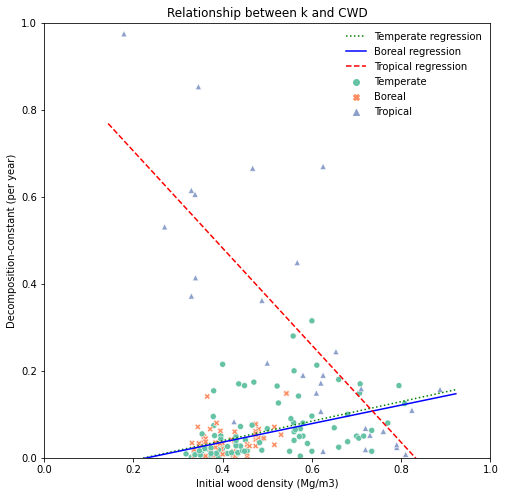

In [231]:
# scatterplot
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax = sns.scatterplot(data=relationship, 
                x='iwd', 
                y='k',
                hue='czone',
                style='czone',
                palette='Set2', 
                markers=['o', 'X', '^'])

# regresion lines
plot_arrangements3 = [('green', ':'), ('blue', '-'), ('red', '--')]
for i,j in zip(czone, plot_arrangements3):
  temp = relationship.loc[relationship.czone == i,]
  sns.regplot(data=temp, 
                x='iwd', 
                y='k',
                line_kws={'color': j[0], 'linestyle': j[1], 'linewidth':1.5},
                scatter=False, 
                ci=None,
                truncate=False,
                label= i + ' regression',
                ax=ax)
ax.set(xlabel='Initial wood density (Mg/m3)', ylabel='Decomposition-constant (per year)',
       title = 'Relationship between k and CWD', xlim=(0,1.0), ylim=(0,1))
ax.legend(frameon=False)
plt.show()

In [229]:
###################################################################
############## LR object for general ##############################
###################################################################
# using Ordinary least squares (ols to analyse the linear regression)
model = smf.ols('k ~ iwd', data=relationship) # dependent ~ independent
res = model.fit()

# list to store result
results = []

# getting values from linear regression
results.append(['Overall',
              str(round(res.params.values[0],3)) + ' (' + str(round(res.bse[0],3)) + ')', 
              str(round(res.params.values[1],3)) + ' (' + str(round(res.bse[1],3)) + ')',
              round(res.rsquared,3),
              round(res.pvalues.values[1],3),
              res.nobs])

###################################################################
############## LR for each czone ##################################
###################################################################
# subset per climate_zone
czone = relationship.czone.unique().tolist()

for i in czone:
  temp = relationship.loc[relationship.czone == i,].reset_index()
  # LR in per climaat zone
  x = temp[['iwd']]
  y = temp[['k']]

  # using Ordinary least squares (ols to analyse the linear regression)
  model = smf.ols('k ~ iwd', data=temp)
  res = model.fit()

  # getting values from linear regression
  results.append([i, 
                str(round(res.params.values[0],3)) + ' (' + str(round(res.bse[0],3)) + ')', 
                str(round(res.params.values[1],3)) + ' (' + str(round(res.bse[1],3)) + ')',
                round(res.rsquared,3),
                round(res.pvalues.values[1],3),
                res.nobs])

In [230]:
# Showing results
res_LinearReg = pd.DataFrame(results, columns=['Biome', 'A', 'b', 'r2', 'P', 'N'])
res_LinearReg.N = res_LinearReg.N.astype(int)
res_LinearReg

,Biome,A,b,r2,P,N
0,Overall,0.087 (0.039),-0.0 (0.079),0.000,0.998,197
1,Temperate,-0.05 (0.023),0.225 (0.046),0.189,0.000,105
2,Boreal,-0.049 (0.028),0.213 (0.066),0.149,0.002,62
3,Tropical,0.929 (0.103),-1.117 (0.171),0.604,0.000,30


**Pretty similar to results!**

# **4. Climatic control**

After reducing the data to only CWD in the downed position, non-linear regression estimated a Q10 of 2.50–2.59 with a base value of k of 0.059 per year at 10 ℃.

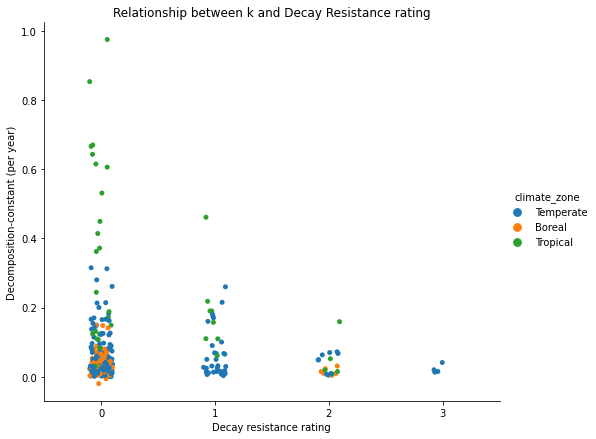

In [223]:
# Decay resitance rating vs k
ax = sns.catplot(x="decay_resistance", 
            y="k(per_year)", 
            hue="climate_zone",
            data=data,
            height=6, aspect=1.2)
ax.set(xlabel='Decay resistance rating', ylabel='Decomposition-constant (per year)',
       title = 'Relationship between k and Decay Resistance rating')
plt.show()

**Decay resistance ratings:**

0 = no to little resistance\
1 = moderate resistance\
2 = resistant\
3 = highly resistant

In [286]:
# Review Reported
ktemperature = data[['decay_resistance', 'positon', 'reported_temperature(c)', 'k(per_year)', 'wc_temperature(c)']].copy()
ktemperature.rename(columns = {'positon': 'cwd_position', 'reported_temperature(c)': 't_reported',
                               'k(per_year)': 'k', 'decay_resistance': 'decay',
                               'wc_temperature(c)': 't_wc'}, inplace = True)
ktemperature.dropna(inplace=True)
ktemperature.reset_index(drop=True, inplace=True)
print('Shape: ', ktemperature.shape)

Shape:  (277, 5)


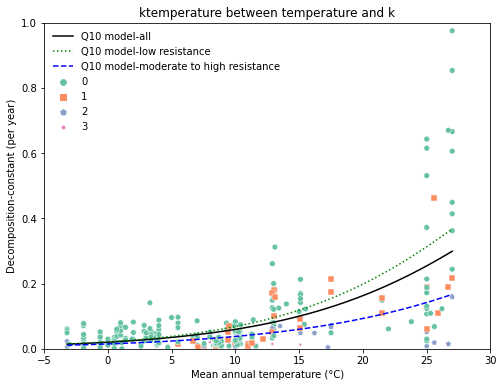

In [287]:
# scatterplot with logistic regression
fig, ax = plt.subplots(1,1, figsize=(8,6))
ax = sns.scatterplot(data=ktemperature, 
                x='t_reported', 
                y='k',
                hue='decay',
                style='decay',
                palette='Set2', 
                markers=['8', 's', 'p', '.'])

# Q10 logistic regression line
sns.regplot(data=ktemperature, 
                x='t_reported', 
                y='k',
                line_kws={'color': 'k', 'linestyle': '-', 'linewidth':1.5},
                scatter=False, 
                ci=None,
                logistic= True,
                label= 'Q10 model-all',
                ax=ax)

# Q10 model-low resistance
temp = ktemperature.loc[ktemperature.decay == 0,]
sns.regplot(data=temp, 
                x='t_reported', 
                y='k',
                line_kws={'color': 'green', 'linestyle': ':', 'linewidth':1.5},
                scatter=False, 
                ci=None,
                logistic= True,
                label= 'Q10 model-low resistance',
                ax=ax)

# Q10 model-moderate to high resistance
temp = ktemperature[ktemperature.decay.isin([1,2,3])]
sns.regplot(data=temp, 
                x='t_reported', 
                y='k',
                line_kws={'color': 'blue', 'linestyle': '--', 'linewidth':1.5},
                scatter=False, 
                ci=None,
                logistic= True,
                label= 'Q10 model-moderate to high resistance',
                ax=ax)

ax.set(xlabel='Mean annual temperature (°C)', ylabel='Decomposition-constant (per year)',
       title = 'Relationship between temperature and k', xlim=(-5,30), ylim=(0,1))
ax.legend(frameon=False)
plt.show()

In [278]:
ktemperature.columns

Index(['decay', 'cwd_position', 't_reported', 'k', 't_wc'], dtype='object')

In [354]:
from statsmodels.tools.tools import add_constant
# Review Reported
ktemperature = data[['decay_resistance', 'positon', 'reported_temperature(c)', 'k(per_year)', 'wc_temperature(c)']].copy()
ktemperature.rename(columns = {'positon': 'cwd_position', 'reported_temperature(c)': 't_reported',
                               'k(per_year)': 'k', 'decay_resistance': 'decay',
                               'wc_temperature(c)': 't_wc'}, inplace = True)

# Q10 relationship between MAR and k
report = [
          ['', 'reported', 'All/reported', ('k', 't_reported'), (0.058, 0.061)],
          ['', 'wc2', 'All/WC2', 'k ~ t_wc'],
          [('cwd_position', ['CWD-downed']), 'reported', 'Downed/reported', 'k ~ t_reported'],
          [('cwd_position', ['CWD-downed']), 'wc2', 'Downed/WC2', 'k ~ t_wc'],
          [('cwd_position', ['CWD-standing']), 'reported', 'Standing/reported', 'k ~ t_reported'],
          [('cwd_position', ['CWD-standing']), 'wc2', 'Standing/WC2', 'k ~ t_wc'],
          [('decay', [0]), 'reported', 'Low decay resistance/reported', 'k ~ t_reported'],
          [('decay', [0]), 'wc2', 'Low decay resistance/WC2', 'k ~ t_wc'],
          [('decay', [1,2,3]), 'reported', 'Standing/reported', 'k ~ t_reported'],
          [('decay', [1,2,3]), 'wc2', 'Standing/WC2', 'k ~ t_wc'],
]

# report list
results = []

# model, fit and getting values
for i in report:
  change, temperature, name, formula, rangek = i
  
  # check fro changes in the dataframe
  if change == '':
    temp = ktemperature.copy()
  else:
    temp = ktemperature[ktemperature[change[0]].isin(change[1])].copy()

  if temperature == 'reported':
    temp.dropna(subset=['t_reported'], inplace=True)
  else:
    temp.dropna(subset=['t_wc'], inplace=True)  

  # Preparing the data
  ##############################################################################
  ######################### HERE IS THE ERROR ##################################
  ##############################################################################
  #
  y = temp[[formula[0]]].copy()
  y[y[formula[0]] < rangek[0]] = 0
  y[y[formula[0]] > rangek[1]] = 0
  y[y[formula[0]] != 0] = 1
  y = y[formula[0]].squeeze()
  # 
  ##############################################################################
  X = add_constant(temp[formula[1]])
  
  # Describe Model
  res = sm.Logit(X, y).fit()
  # saving the values in list
  results.append([name, 
            str(round(res.params.values[0],3)) + ' (' + str(round(res.bse[0],3)) + ')', 
            str(round(res.params.values[1],3)) + ' (' + str(round(res.bse[1],2)) + ')',
            round(res.rsquared,3),
            round(res.pvalues.values[1],3),
            int(res.nobs)])
  

ValueError: ignored

In [302]:
# Showing results
res_LogitReg = pd.DataFrame(results, columns=['Model', 'k10', 'Q10', 'r2', 'p', 'N'])
res_LogitReg.N = res_LogitReg.N.astype(int)
res_LogitReg

,Model,k10,Q10,r2,p,N
0,All/reported,-0.007 (0.01),0.009 (0.0),0.335,0.000,277
1,All/WC2,-0.011 (0.01),0.01 (0.0),0.327,0.000,295
2,Downed/reported,-0.015 (0.012),0.01 (0.0),0.338,0.000,244
3,Downed/WC2,-0.016 (0.012),0.011 (0.0),0.328,0.000,262
4,Standing/reported,0.021 (0.005),-0.001 (0.0),0.025,0.433,27
5,Standing/WC2,0.023 (0.006),-0.001 (0.0),0.035,0.349,27
6,Low decay resistance/reported,-0.01 (0.011),0.011 (0.0),0.407,0.000,214
7,Low decay resistance/WC2,-0.016 (0.011),0.012 (0.0),0.391,0.000,229
8,Standing/reported,-0.008 (0.016),0.005 (0.0),0.295,0.000,63
9,Standing/WC2,-0.009 (0.017),0.006 (0.0),0.298,0.000,66


# **5. Relationship between TAP and k at different decay resistance**

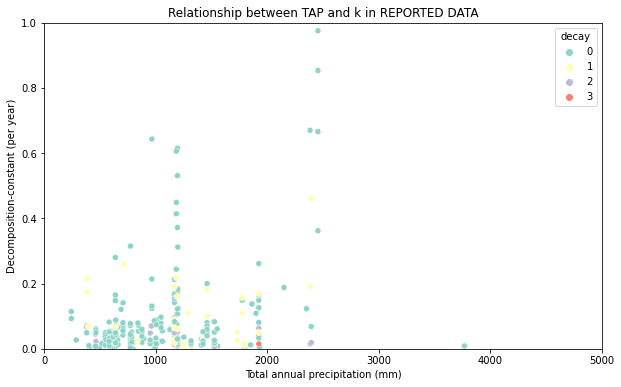

In [373]:
# Climatic conditions of decomposition studies for coarse worry detritus based
# on climate reported studies
tap_reported = data[['decay_resistance','wc_precipitation(mm_per_year)', 'k(per_year)']].copy()
tap_reported.rename(columns={'decay_resistance':'decay', 
                             'wc_precipitation(mm_per_year)':'tpa_rep',
                             'k(per_year)':'k'}, inplace=True)

# fixing -99 empty data
tap_reported['tpa_rep'] = np.where(tap_reported['tpa_rep']== -99, np.nan, tap_reported['tpa_rep'])

# scatterplot
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax = sns.scatterplot(data=tap_reported, 
                x='tpa_rep',
                y='k',
                hue='decay',
                palette='Set3')
ax.set(xlabel='Total annual precipitation (mm)', ylabel='Decomposition-constant (per year)',
       title = 'Relationship between TAP and k in REPORTED DATA',
       xlim=(0,5000),ylim=(0,1))
plt.show()

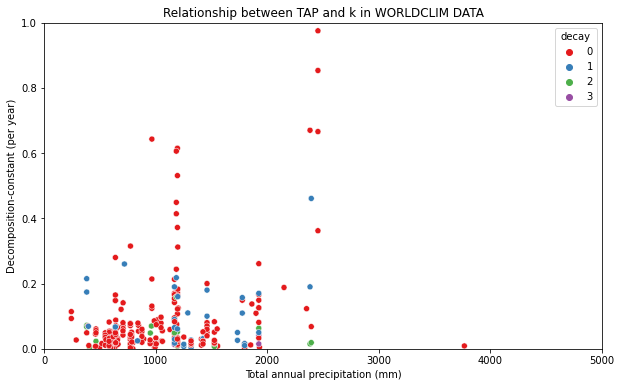

In [372]:
# Climatic conditions of decomposition studies for coarse worry detritus based
# on climate reported studies
tap_wc = data[['decay_resistance','wc_precipitation(mm_per_year)', 'k(per_year)']].copy()
tap_wc.rename(columns={'decay_resistance':'decay', 
                             'wc_precipitation(mm_per_year)':'tpa_wc',
                             'k(per_year)':'k'}, inplace=True)

# fixing -99 empty data
tap_wc['tpa_wc'] = np.where(tap_wc['tpa_wc']== -99, np.nan, tap_wc['tpa_wc'])

# scatterplot
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax = sns.scatterplot(data=tap_wc, 
                x='tpa_wc',
                y='k',
                hue='decay',
                palette='Set1')
ax.set(xlabel='Total annual precipitation (mm)', ylabel='Decomposition-constant (per year)',
       title = 'Relationship between TAP and k in WORLDCLIM DATA',
       xlim=(0,5000),ylim=(0,1))
plt.show()

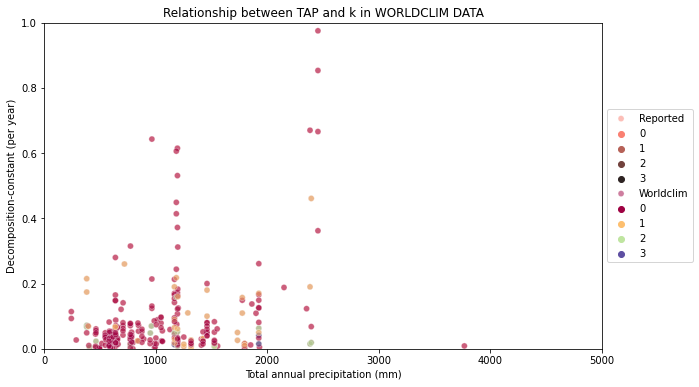

In [387]:
# Comparing both plots
# scatterplot
fig, ax = plt.subplots(1,1, figsize=(10,6))
sns.scatterplot(data=tap_wc, 
                x='tpa_wc',
                y='k',
                hue='decay',
                palette='dark:salmon_r',
                alpha=0.5,
                label='Reported', ax=ax)
sns.scatterplot(data=tap_wc, 
                x='tpa_wc',
                y='k',
                hue='decay',
                palette='Spectral',
                alpha=0.5,
                label='Worldclim', ax=ax)
ax.set(xlabel='Total annual precipitation (mm)', ylabel='Decomposition-constant (per year)',
       title = 'Relationship between TAP and k in WORLDCLIM DATA',
       xlim=(0,5000),ylim=(0,1))
plt.legend(loc='center left', bbox_to_anchor=(1., 0.5))
plt.show()

In [ ]:
# Review taxonomic information
fig, axs = plt.subplots(1,2, figsize=(12,25))
data['scientific'] = data['genus']+data['species'] # latin name or genus + species. (not relevant now)
taxonomy = ['family', 'genus']
for ax, i in zip(axs.ravel(),taxonomy):
  sns.countplot(y=i, data=data, ax=ax)
  ax.set_title(str.capitalize(i))
plt.tight_layout()
plt.show()